In [1]:
#reference
#https://medium.com/analytics-vidhya/re-sampling-imbalanced-training-corpus-for-sentiment-analysis-c9dc97f9eae1
#https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
#https://www.datasciencecentral.com/handling-imbalanced-data-sets-in-supervised-learning-using-family/
#https://towardsdatascience.com/comparative-analysis-of-oversampling-techniques-on-imbalanced-data-cd46f172d49d
#https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
#python
#https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler.fit_resample
#https://pypi.org/project/imbalanced-learn/

#details on ADASYN
#https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa
#https://medium.com/quantyca/oversampling-and-undersampling-adasyn-vs-enn-60828a58db39


In [2]:
from sklearn import model_selection, preprocessing, metrics, linear_model, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (RandomUnderSampler, 
                                    NearMiss, 
                                    InstanceHardnessThreshold,
                                    CondensedNearestNeighbour,
                                    EditedNearestNeighbours,
                                    RepeatedEditedNearestNeighbours,
                                    AllKNN,
                                    NeighbourhoodCleaningRule,
                                    OneSidedSelection,
                                    TomekLinks)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
import pandas as pd, numpy, string
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

#Remove Special Charactors
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


#pipeline
from numpy import where
from matplotlib import pyplot

In [3]:
#randome forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
#Resampling_Pipeline function
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestClassifier as RF

In [5]:
import os
os.chdir('/Users/akiratachibana/Downloads/Classes/ECON4763/Project')

import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split


#Import Training and Testing Data
train = pd.read_csv('hate_dataset.csv')
print("Training Set:"% train.columns, train.shape, len(train))

Training Set: (31962, 3) 31962


In [6]:
#data cleaning
porter=PorterStemmer()
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    #Stemming
    stem_sentence=[]
    for word in words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    words="".join(stem_sentence).strip()
    return words

nums = [0,len(train)]
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    clean_tweet_texts.append(tweet_cleaner(train['tweet'][i]))

    
train_clean = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
train_clean['label'] = train.label
train_clean['id'] = train.id



In [7]:
#split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_clean['tweet'],train_clean['label'])

#label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [8]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(train_clean['tweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [9]:
#Percentage of Positive/Negative
print("Positive: ", train.label.value_counts()[0]/len(train)*100,"%")
print("Negative: ", train.label.value_counts()[1]/len(train)*100,"%")

print("Positive: ", train.label.value_counts()[0])
print("Negative: ", train.label.value_counts()[1])

Positive:  92.98542018647143 %
Negative:  7.014579813528565 %
Positive:  29720
Negative:  2242


## <font color='green'> Original model accuracy without resampling

In [11]:
#Return the f1 Score
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.f1_score(valid_y,predictions)

In [12]:
accuracyORIGINAL_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR Baseline, WordLevel TFIDF: ", accuracyORIGINAL_LR)
accuracyORIGINAL_SVM = train_model(svm.LinearSVC(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("SVM Baseline, WordLevel TFIDF: ", accuracyORIGINAL_SVM)
accuracySMOTE_RF = train_model(RF(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF Baseline, WordLevel TFIDF: ", accuracyORIGINAL_SVM)

LR Baseline, WordLevel TFIDF:  0.5446009389671361
SVM Baseline, WordLevel TFIDF:  0.6853002070393375
RF Baseline, WordLevel TFIDF:  0.6853002070393375


In [19]:
def ResamplingPipe(Model):
    score_list_LR = []
    score_list_SVM = []
    score_list_LR.append(accuracyORIGINAL_LR)
    score_list_SVM.append(accuracyORIGINAL_SVM)
    ratios = [0.25,0.5,0.75,1]
    
    for ratio in ratios:
        over = Model(sampling_strategy=ratio, random_state=777)
        steps = [('o', over)]
        pipeline = Pipeline(steps=steps)
        new_xtrain_tfidf, new_train_y = pipeline.fit_resample(xtrain_tfidf, train_y)
        
        accuracySMOTE_LR = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial', max_iter=1000),new_xtrain_tfidf, new_train_y, xvalid_tfidf)
        print ("LR, WordLevel TFIDF: ", accuracySMOTE_LR)
        score_list_LR.append(accuracySMOTE_LR)
        
        accuracySMOTE_SVM = train_model(svm.LinearSVC(),new_xtrain_tfidf, new_train_y, xvalid_tfidf)
        print ("SVM, WordLevel TFIDF: ", accuracySMOTE_SVM)
        score_list_SVM.append(accuracySMOTE_SVM)
        
        
        #tuned_params = {'n_estimators': [10, 50, 100, 500, 1000], 'max_depth':[None], 'max_features': [math.floor(math.sqrt(n_features))], 'min_samples_split': [2],}
        #accuracySMOTE_RF = train_model(RF(), new_xtrain_tfidf, new_train_y, xvalid_tfidf)
        #print ("SVM, WordLevel TFIDF: ", accuracySMOTE_SVM)
        #score_list_RF.append(accuracySMOTE_SVM)
        
    ratios.insert(0, 0.0)
    xlabel = "Oversampling Ratio"
    ylabel = "F1 Score"
    fig, ax = plt.subplots(figsize=(4, 4))
    plotData(score_list_LR ,ratios, 5, xlabel, ylabel, ax, 'blue', lab="Logistic Regresssion")
    plotData(score_list_SVM ,ratios, 5, xlabel, ylabel, ax, 'red', lab="Support Vector Machine")
    #ax.set_ylim([0, 1])
    ax.legend(bbox_to_anchor = (1.0, 1), loc = 'lower right')
    
    ROS_list = [score_list_LR, score_list_SVM]
    
    plt.show()
    
    return ROS_list
    

In [13]:
def plotData(Data, x, d, xlabel, ylabel, ax, color, lab):
    best_model = max(Data)

    for i in range(0, d):
        if(Data[i] == best_model):
            max_n = i
    
    ax.plot(x, Data, color=color,marker='o', markerfacecolor=color, markersize=8, label=lab)
    ax.plot(x[max_n], best_model, marker='x', markersize=20,  markerfacecolor=color)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#https://stackoverflow.com/questions/50245684/using-smote-with-gridsearchcv-in-scikit-learn/50245954
def ResamplingPipe2(Model):
    score_list = []
    score_list.append(accuracyORIGINAL)
    ratios = [0.25,0.5,0.75,1]
    params_for_method = { 'random_state': [777], 'sampling_strategy': ratios}
    

    model = Pipeline([
        ('sampling', Model()),
        ('classification', linear_model.LogisticRegression())
    ])

    grid = GridSearchCV(model, params_for_method, cv=5, scoring='f1')
    clf = grid.fit(xtrain_tfidf, train_y)
    print()
    print()
    print("Best parameters set found on train set:")
    print(clf.best_params_)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    score_list = means
        
    ratios.insert(0, 0.0)
    plt.plot(ratios, score_list)
    plt.xlabel("Oversampling Ratio")
    y = np.range(0,1)
    plt.ylabel("F1 Score")
    plt.show() 

## <font color='green'> Random Over-sampling

LR, WordLevel TFIDF:  0.687559354226021
SVM, WordLevel TFIDF:  0.7220149253731344
LR, WordLevel TFIDF:  0.7136788445199661
SVM, WordLevel TFIDF:  0.7133984028393967
LR, WordLevel TFIDF:  0.7007182761372707
SVM, WordLevel TFIDF:  0.706806282722513
LR, WordLevel TFIDF:  0.6916030534351144
SVM, WordLevel TFIDF:  0.6998284734133792


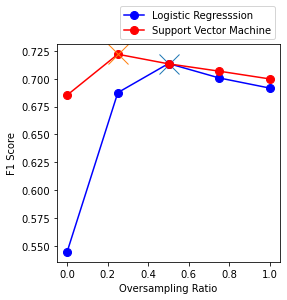

In [20]:
ROS_list = ResamplingPipe(RandomOverSampler)

## <font color='green'> SMOTE Over-sampling

LR, WordLevel TFIDF:  0.6666666666666667
SVM, WordLevel TFIDF:  0.700197238658777
LR, WordLevel TFIDF:  0.681985294117647
SVM, WordLevel TFIDF:  0.6778087279480037
LR, WordLevel TFIDF:  0.6791489361702128
SVM, WordLevel TFIDF:  0.6799276672694395
LR, WordLevel TFIDF:  0.6704918032786885
SVM, WordLevel TFIDF:  0.6779359430604982
0.5402010050251257
0.6666666666666667
0.681985294117647
0.6791489361702128
0.6704918032786885
0.692896174863388
0.700197238658777
0.6778087279480037
0.6799276672694395
0.6779359430604982


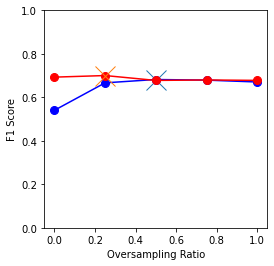

In [47]:
SMOTE_list = ResamplingPipe(SMOTE)

## <font color='green'> ADASYN: Adaptive synthetic sampling (Over-sampling)

LR, WordLevel TFIDF:  0.6727272727272728
SVM, WordLevel TFIDF:  0.6828793774319066
LR, WordLevel TFIDF:  0.6760070052539405
SVM, WordLevel TFIDF:  0.6819012797074955
LR, WordLevel TFIDF:  0.6694352159468439
SVM, WordLevel TFIDF:  0.6761819803746655
LR, WordLevel TFIDF:  0.6546026750590087
SVM, WordLevel TFIDF:  0.6725352112676056
0.5402010050251257
0.6727272727272728
0.6760070052539405
0.6694352159468439
0.6546026750590087
0.692896174863388
0.6828793774319066
0.6819012797074955
0.6761819803746655
0.6725352112676056


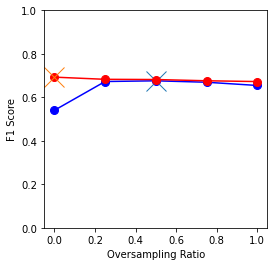

In [48]:
ADASYN_list = ResamplingPipe(ADASYN)

## <font color='green'> SMOTE-NC

#SMOTENC
smnc = SMOTENC(categorical_features=[0, 2], random_state=0)
smnc_xtrain_tfidf, smnc_train_y = smnc.fit_sample(xtrain_tfidf, train_y)
accuracySMOTENC = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),smnc_xtrain_tfidf, smnc_train_y, xvalid_tfidf)
print ("LR SMOTENC, WordLevel TFIDF: ", accuracySMOTENC)
accuracySMOTENC = train_model(svm.LinearSVC(),smnc_xtrain_tfidf, smnc_train_y, xvalid_tfidf)
print ("SVM SMOTENC, WordLevel TFIDF: ", accuracySMOTENC)

## <font color='green'> Borderline SMOTE

LR, WordLevel TFIDF:  0.6735112936344969
SVM, WordLevel TFIDF:  0.6917740336967294
LR, WordLevel TFIDF:  0.6877323420074349
SVM, WordLevel TFIDF:  0.6886792452830189
LR, WordLevel TFIDF:  0.6707105719237436
SVM, WordLevel TFIDF:  0.6794871794871795
LR, WordLevel TFIDF:  0.6605351170568562
SVM, WordLevel TFIDF:  0.6756513926325247
0.5402010050251257
0.6735112936344969
0.6877323420074349
0.6707105719237436
0.6605351170568562
0.692896174863388
0.6917740336967294
0.6886792452830189
0.6794871794871795
0.6756513926325247


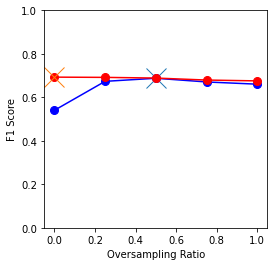

In [49]:
BS_list = ResamplingPipe(BorderlineSMOTE)

In [50]:
ROS_list[0]#2

[0.5402010050251257,
 0.686414708886619,
 0.6943192064923354,
 0.6823134953897737,
 0.6639935846030472]

In [51]:
SMOTE_list[0]#2

[0.5402010050251257,
 0.6666666666666667,
 0.681985294117647,
 0.6791489361702128,
 0.6704918032786885]

In [52]:
ADASYN_list[0]#2

[0.5402010050251257,
 0.6727272727272728,
 0.6760070052539405,
 0.6694352159468439,
 0.6546026750590087]

In [53]:
BS_list[0]#2

[0.5402010050251257,
 0.6735112936344969,
 0.6877323420074349,
 0.6707105719237436,
 0.6605351170568562]

In [54]:
ROS_list[1]#1

[0.692896174863388,
 0.6981317600786627,
 0.6820702402957486,
 0.6792792792792792,
 0.6785079928952042]

In [55]:
SMOTE_list[1]#1

[0.692896174863388,
 0.700197238658777,
 0.6778087279480037,
 0.6799276672694395,
 0.6779359430604982]

In [56]:
ADASYN_list[1]#0

[0.692896174863388,
 0.6828793774319066,
 0.6819012797074955,
 0.6761819803746655,
 0.6725352112676056]

In [57]:
BS_list[1]#0

[0.692896174863388,
 0.6917740336967294,
 0.6886792452830189,
 0.6794871794871795,
 0.6756513926325247]

## <font color='green'> Visualization

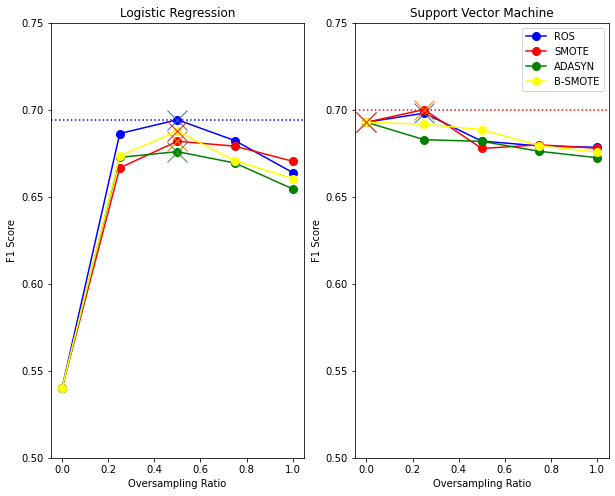

In [88]:
xlabel = 'Oversampling Ratio'
ylabel = 'F1 Score'
d = 5

ratios = [0.0, 0.25, 0.5, 0.75, 1]
fig, (ax1, ax2) =  plt.subplots(1,2, figsize=(10,8))
plotData(ROS_list[0], ratios, 5, xlabel, ylabel, ax1, color="blue", lab='ROS')
plotData(SMOTE_list[0] ,ratios, 5, xlabel, ylabel, ax1, color="red", lab='SMOTE')
plotData(ADASYN_list[0] ,ratios, 5, xlabel, ylabel, ax1, color="green", lab='ADASYN')
plotData(BS_list[0] ,ratios, 5, xlabel, ylabel, ax1, color="yellow",lab='B-SMOTE')
ax1.set_ylim([0.5, 0.75])
ax1.set_title('Logistic Regression')
ax1.axhline(y =0.6943192064923354, color = 'blue', linestyle = ':')
    
plotData(ROS_list[1], ratios, 5, xlabel, ylabel, ax2, color="blue",lab='ROS')
plotData(SMOTE_list[1] ,ratios, 5, xlabel, ylabel, ax2, color="red", lab='SMOTE')
plotData(ADASYN_list[1] ,ratios, 5, xlabel, ylabel, ax2, color="green",lab='ADASYN')
plotData(BS_list[1] ,ratios, 5, xlabel, ylabel, ax2, color="yellow", lab='B-SMOTE')
ax2.set_ylim([0.5, 0.75])
ax2.axhline(y =0.700197238658777, color = 'red', linestyle = ':')
ax2.set_title('Support Vector Machine')
ax2.legend(bbox_to_anchor = (1.0, 1), loc = 'upper right')

plt.show()

## <font color='green'> Summary